In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import torch.backends.cudnn as cudnn

# import custom modules
from datasets.data_loader import *
from models.clamer import *
from models.loss import InfoNCELoss
from models.trfm import *
from utils.utils import *
from utils.plot_figures import *
from utils.metrics import *
from utils.build_vocab import *

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from matplotlib import pyplot as plt
from utils.build_vocab import WordVocab
from models.trfm import *

KeyboardInterrupt: 

In [ ]:
def sample_clamer(temp, model, sample_dataloader, device, vocab):
    '''ArithmeticError
    Generate SMILES strings using the trained GPT model with sampling.
    
    Args:
        temp (float): The temperature parameter for sampling.
        model (CLAMER): The pre-trained GPT model for token generation.
        sample_dataloader (DataLoader): The data loader for the SMILES dataset.
        device (torch.device): The device on which to run the generation.
        vocab: The vocabulary object for encoding and decoding SMILES strings.
    
    Returns:
        List[float]: A list of negative log-likelihoods for the generated SMILES strings.
        List[str]: A list of generated SMILES strings.
    '''
    sample_nll_total = []
    smiles_gen_total = []
    with torch.no_grad():
        for batch_idx, (zeo, syn, tgt) in enumerate(tqdm(sample_dataloader)):
            # Generate the target sequence for the model
            target = [SOS] + [PAD] * 218
            tgt_seq = torch.LongTensor(target).unsqueeze(0).expand(zeo.size(0), len(target)).to(device)
            batch_size = zeo.size(0)
            # Move input tensors to the device
            zeo, syn = zeo.to(device), syn.to(device)
            smiles_gen = [[''] * batch_size][0]
            sample_nll = [0] * batch_size
            finished = np.array([False] * batch_size, dtype=object)
            end_char = '<eos>'
            for i in range(218):
                net_out = model(zeo, syn, tgt_seq)[:, i + 2, :]
                o = F.softmax(net_out, dim=-1).cpu().detach().numpy()
                # sample temp
                if temp != 0:
                    temp = abs(temp)  # No negative values
                    next_char_probs = np.log(o) / temp
                    next_char_probs = np.exp(next_char_probs)
                    next_char_probs = next_char_probs.astype(float)
                    next_char_probs = (next_char_probs.T / (next_char_probs.sum(axis=1))).T
                    sampleidc = torch.tensor(
                        [np.random.multinomial(1, next_char_prob, 1).argmax() for next_char_prob in
                            next_char_probs])
                else:
                    sampleidc = torch.tensor(np.argmax(o, axis=1))

                samplechars = [vocab.itos[idx] for idx in sampleidc.numpy()]

                for idx, samplechar in enumerate(samplechars):
                    if not finished[idx]:
                        if samplechar != end_char:
                            # Append the SMILES with the next character
                            smiles_gen[idx] += samplechar
                            tgt_seq[:, i + 1] = sampleidc.to(device)
                            # Calculate negative log likelihood for the selected character
                            sample_nll[idx] -= np.log(o[idx][sampleidc[idx]])
                        else:
                            finished[idx] = True
                            # print("SMILES has finished at %i" %i)
                # If all SMILES are finished, i.e. the end_char "<eos>" has been generated, stop the generation
            if finished.sum() == len(finished):
                sample_nll_total += sample_nll
                smiles_gen_total += smiles_gen
                    
    return sample_nll_total, smiles_gen_total

In [ ]:
# load the data
AFI_smiles = read_strings('./data_AFI/AFI_smiles.csv', idx=False)
AFI_zeo = read_vec('./data_AFI/AFI_zeo.csv', idx=False)
AFI_syn = read_vec('./data_AFI/AFI_syn.csv', idx=False)
CHA_smiles = read_strings('./data_CHA/CHA_smiles.csv', idx=False)
CHA_zeo = read_vec('./data_CHA/CHA_zeo.csv', idx=False)
CHA_syn = read_vec('./data_CHA/CHA_syn.csv', idx=False)
AEI_smiles = read_strings('./data_AEI/AEI_smiles.csv', idx=False)
AEI_zeo = read_vec('./data_AEI/AEI_zeo.csv', idx=False)
AEI_syn = read_vec('./data_AEI/AEI_syn.csv', idx=False)
train_smiles = read_strings('./data/train_smiles.csv', idx=False)
test_smiles = read_strings('./data/test_smiles.csv', idx=False)
# merge the training and testing smiles, thay
train_smiles = train_smiles.tolist()
test_smiles = test_smiles.tolist()
train_smiles = [i[0] for i in train_smiles]
test_smiles = [i[0] for i in test_smiles]
all_smiles = train_smiles + test_smiles
print(all_smiles[:5])

vocab = WordVocab.load_vocab('./model_hub/vocab.pkl')
print('the vocab size is :', len(vocab))

charlen = len(vocab)
print('the total num of charset is :', charlen)

vocab_size = len(vocab)

cudnn.benchmark = True
batch_size = 64

manual_seed = 42
random.seed(manual_seed)
torch.manual_seed(manual_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create the dataset and dataloader
AFI_dataset = Seq2seqDataset(AFI_zeo, AFI_syn, AFI_smiles, vocab)
CHA_dataset = Seq2seqDataset(CHA_zeo, CHA_syn, CHA_smiles, vocab)
AEI_dataset = Seq2seqDataset(AEI_zeo, AEI_syn, AEI_smiles, vocab)
AFI_dataloader = DataLoader(AFI_dataset, batch_size=batch_size, shuffle=True)
CHA_dataloader = DataLoader(CHA_dataset, batch_size=batch_size, shuffle=False)
AEI_dataloader = DataLoader(AEI_dataset, batch_size=batch_size, shuffle=False)

['n1(C)c(C)[n+](cc1)Cc1ccccc1C[n+]1ccn(C)c1C', 'Cn1cc[n+](Cc2ccccc2C[n+]2ccn(C)c2C)c1C', 'Cc1n(C)cc[n+]1Cc1c(cccc1)C[n+]1ccn(c1C)C', 'c1ccc(c(c1)C[n+]1c(C)n(C)cc1)C[n+]1ccn(c1C)C', '[n+]1(c(n(C)cc1)C)Cc1c(C[n+]2ccn(c2C)C)cccc1']
the vocab size is : 45
the total num of charset is : 45


In [ ]:
pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4

PAD = 0
UNK = 1
EOS = 2
SOS = 3
MASK = 4
MAX_LEN = 220

# load model
# trfm = TrfmSeq2seq(charlen, 256, charlen, 4).to(device)
trfm = TrfmSeq2seq(charlen, 256, charlen, 4)
trfm.load_state_dict(torch.load('./model_hub/trfm_new_2_10000.pkl'))
trfm.eval()

# set trfm gradient to false which won't be updated
for param in trfm.parameters():
    param.requires_grad = False

# calculate the number of parameters
print('Number of parameters: {}'.format(sum(p.numel() for p in trfm.parameters())))

Number of parameters: 4245037


In [ ]:
d_model = 128
head = 4

model = GptCovd(d_model=d_model, charlen=charlen, device=device, head=head)

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    model.to(device)
    return model

In [ ]:
# def generate(path, model, dataloader, device, vocab):
#     model = load_model(model, path)
#     model.eval()
#     nll, generate_smiles = sample_clamer(0.5, model, dataloader, device, vocab)
#     return nll, generate_smiles

# # generate the smiles
# AFI_generate_smiles = pd.DataFrame()
# for i in range(6):
#     path = './checkpoints/clamer/clamer_contrastive_model_{}.pth'.format(i)
#     nll, smiles = generate(path, model, AFI_dataloader, device, vocab)
#     smiles = pd.DataFrame(smiles, columns=['epoch_{}'.format(i)])
#     AFI_generate_smiles = pd.concat([AFI_generate_smiles, smiles], axis=1)

# # save the generated smiles
# AFI_generate_smiles.to_csv('./generation/AFI_generate_smiles.csv', index=False)

In [ ]:
# CHA_generate_smiles = pd.DataFrame()
# for i in range(6):
#     path = './checkpoints/clamer/clamer_contrastive_model_{}.pth'.format(i)
#     nll, smiles = generate(path, model, CHA_dataloader, device, vocab)
#     smiles = pd.DataFrame(smiles, columns=['epoch_{}'.format(i)])
#     CHA_generate_smiles = pd.concat([CHA_generate_smiles, smiles], axis=1)

# # save the generated smiles
# CHA_generate_smiles.to_csv('./generation/CHA_generate_smiles.csv', index=False)

In [ ]:
# AEI_generate_smiles = pd.DataFrame()
# for i in range(6):
#     path = './checkpoints/clamer/clamer_contrastive_model_{}.pth'.format(i)
#     nll, smiles = generate(path, model, AEI_dataloader, device, vocab)
#     smiles = pd.DataFrame(smiles, columns=['epoch_{}'.format(i)])
#     AEI_generate_smiles = pd.concat([AEI_generate_smiles, smiles], axis=1)

# # save the generated smiles
# AEI_generate_smiles.to_csv('./generation/AEI_generate_smiles.csv', index=False)

In [ ]:
def smiles_to_vec(Smiles, vocab, trfm):
    def get_inputs(sm):
        seq_len = 220
        sm = sm.split()
        if len(sm)>218:
            print('SMILES is too long ({:d})'.format(len(sm)))
            sm = sm[:109]+sm[-109:]
        ids = [vocab.stoi.get(token, unk_index) for token in sm]
        ids = [sos_index] + ids + [eos_index]
        seg = [1]*len(ids)
        padding = [pad_index]*(seq_len - len(ids))
        ids.extend(padding), seg.extend(padding)
        return ids, seg
    def get_array(smiles):
        x_id, x_seg = [], []
        for sm in smiles:
            a,b = get_inputs(sm)
            x_id.append(a)
            x_seg.append(b)
        return torch.tensor(x_id), torch.tensor(x_seg)
    x_split = [split(sm) for sm in Smiles]
    xid, xseg = get_array(x_split)
    # xid = xid.to(device)
    X = trfm.encode(torch.t(xid))
    return X

In [ ]:
# load the generated smiles
AFI_generate_smiles = pd.read_csv('./generation/AFI_generate_smiles.csv')
CHA_generate_smiles = pd.read_csv('./generation/CHA_generate_smiles.csv')
AEI_generate_smiles = pd.read_csv('./generation/AEI_generate_smiles.csv')
all_smiles_unique = pd.read_csv('./data/all_smiles_unique.csv')

def validity_smiles(smiles):
    valid = []
    for smile in smiles:
        try:
            Chem.MolFromSmiles(smile)
            valid.append(smile)
        except:
            continue
    return valid

# get the valid smiles
AFI_generate_smiles = AFI_generate_smiles.apply(validity_smiles)
CHA_generate_smiles = CHA_generate_smiles.apply(validity_smiles)
AEI_generate_smiles = AEI_generate_smiles.apply(validity_smiles)
# all_smiles_unique = all_smiles_unique.apply(validity_smiles)

def random_sample(df, n):
    df_sample = pd.DataFrame()
    for i in range(6):
        smiles = df['epoch_{}'.format(i)]
        smiles = random.sample(smiles, n)
        smiles = pd.DataFrame(smiles, columns=['epoch_{}'.format(i)])
        df_sample = pd.concat([df_sample, smiles], axis=1)
    return df_sample
    

AFI_generate_smiles = random_sample(AFI_generate_smiles, 50)
CHA_generate_smiles = random_sample(CHA_generate_smiles, 50)
AEI_generate_smiles = random_sample(AEI_generate_smiles, 50)

def get_vec(df, vocab, trfm, epoch):
    df_smiles = df['epoch_{}'.format(epoch)]
    if isinstance(df_smiles, pd.Series):
        df_smiles = df_smiles.tolist()
    # convert the smiles to vec
    vec = smiles_to_vec(df_smiles, vocab, trfm)
    return vec

# get the vec for the generated smiles
# AFI_generated_vec = get_vec(AFI_generate_smiles, vocab, trfm, 0)

[18:50:17] SMILES Parse Error: unclosed ring for input: 'C1C2CC3CC(C2)CC1CC1[N+](C)(C)C'
[18:50:17] SMILES Parse Error: unclosed ring for input: 'C1C2CCCC1C[N+]1(CC2)CCCCC[N+]12CCC(CC2)CC1'
[18:50:17] SMILES Parse Error: unclosed ring for input: 'c1cc(ccc1)C[N+]1(CCCC1)CCCCC1C'
[18:50:17] Can't kekulize mol.  Unkekulized atoms: 0 1 2 9 10
[18:50:17] SMILES Parse Error: unclosed ring for input: 'c1ccc2c(cc1)C[N+](C)(C)Cc2ccccc2'
[18:50:17] Explicit valence for atom # 8 F, 2, is greater than permitted
[18:50:17] SMILES Parse Error: unclosed ring for input: 'c1ccccc1CN1C(CO)Cc1ccccc1'
[18:50:17] SMILES Parse Error: unclosed ring for input: 'C1CCCCCC2C1CC1[N+](C)(C)CC2'
[18:50:17] Explicit valence for atom # 4 N, 4, is greater than permitted
[18:50:17] SMILES Parse Error: unclosed ring for input: 'C1C2CC(C1)C1CCCC2[N+]1(C)CCCCC1'
[18:50:17] Can't kekulize mol.  Unkekulized atoms: 0 1 2 11 12 13 14
[18:50:17] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[18:50:17] SMILES Parse Error: u

In [ ]:
# randomize the all_smiles_unique
# every smiles generate 10 new smiles
def smiles_randomize(smiles, num=10):
    new_smiles = []
    for i in range(len(smiles)):
        for j in range(num):
            # using rdkit to randomize the smiles
            mol = Chem.MolFromSmiles(smiles[i])
            if mol is None:
                continue
            new_smiles.append(Chem.MolToSmiles(mol, canonical=False))
    return new_smiles

all_smiles = [smiles for smiles in all_smiles_unique['smiles']]
print(all_smiles[:5])
print(type(all_smiles))
all_smiles = smiles_randomize(all_smiles)
print(len(all_smiles))

['CC1CCCCN1', 'CC1CCCC[N+]1(C)C', 'NC1CCCC1', 'C[N+]1(C)CC2CCC(CC2)C1', 'CCNCCN(C)C']
<class 'list'>
7050


In [ ]:
# convert AFI, AEI, CHA to list like ['CCO', 'CCN']
AFI_smiles = AFI_smiles.tolist()
AFI_smiles = [i[0] for i in AFI_smiles]
print(AFI_smiles[:5])
CHA_smiles = CHA_smiles.tolist()
CHA_smiles = [i[0] for i in CHA_smiles]
AEI_smiles = AEI_smiles.tolist()
AEI_smiles = [i[0] for i in AEI_smiles]

# randomize the AFI, AEI, CHA smiles
AFI_smiles = smiles_randomize(AFI_smiles, 20)
CHA_smiles = smiles_randomize(CHA_smiles, 20)
AEI_smiles = smiles_randomize(AEI_smiles, 20)

['CN(C1CCCCC1)C2CCCCC2', 'CCC[N+](CCC)(CCC)CCC', 'CN(C1CCCCC1)C2CCCCC2', 'CN(C)c1ccncc1', 'CCN(CC)CC']


In [ ]:
# convert the smiles to vec
all_vec = smiles_to_vec(all_smiles, vocab, trfm)
print(all_vec.shape)

torch.Size([7050, 1024])


In [ ]:
# 降维函数
def PCA_reduce(data, n_components=2):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data)

def tSNE_reduce(data, n_components=2):
    tsne = TSNE(n_components=n_components)
    return tsne.fit_transform(data)

def UMAP_reduce(data, n_components=2):
    umap = UMAP(n_components=n_components)
    return umap.fit_transform(data)

In [ ]:
# def draw_scatter_epochs(all_vec, origin_smiles, generated_smiles, method='PCA', epochs=10):
    
#     fig, axes = plt.subplots(1, epochs, figsize=(18, 5), dpi=300)
    
#     # remove all charts border
#     for ax in axes:
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         ax.spines['bottom'].set_visible(False)
#         ax.spines['left'].set_visible(False)
#         ax.set_xticks([])
#         ax.set_yticks([])
    
#     # convert origin_smiles to vec
#     origin_vec = smiles_to_vec(origin_smiles, vocab, trfm)
#     # reduce the dimension
#     if method == 'PCA':
#         origin_vec = PCA_reduce(origin_vec)
#         all_vec = PCA_reduce(all_vec)
#     elif method == 'tSNE':
#         origin_vec = tSNE_reduce(origin_vec)
#         all_vec = tSNE_reduce(all_vec)
#     elif method == 'UMAP':
#         origin_vec = UMAP_reduce(origin_vec)
#         all_vec = UMAP_reduce(all_vec)
    
#     for i in range(epochs):
#         # get generated smiles vec
#         generated_vec = get_vec(generated_smiles, vocab, trfm, i)
#         # reduce the dimension
#         if method == 'PCA':
#             generated_vec = PCA_reduce(generated_vec)
#         elif method == 'tSNE':
#             generated_vec = tSNE_reduce(generated_vec)  
#         elif method == 'UMAP':
#             generated_vec = UMAP_reduce(generated_vec)
#         # draw the scatter plot
#         axes[i].scatter(all_vec[:, 0], all_vec[:, 1], c='grey', s=5, label='All OSDAs SMILES')
#         axes[i].scatter(origin_vec[:, 0], origin_vec[:, 1], c='blue', s=5, label='Source SMILES')
#         axes[i].scatter(generated_vec[:, 0], generated_vec[:, 1], c='red', s=5, label='Generated SMILES')
#     plt.show()

In [ ]:
def draw_scatter_epochs(all_vec, origin_smiles, generated_smiles, method='PCA', epochs=10, cmap='coolwarm', alpha=0.7):
    """
    Draws scatter plots for dimensionality reduction of SMILES vectors over multiple epochs.

    Parameters:
        all_vec (numpy.ndarray): The complete vector representation of all SMILES.
        origin_smiles (list): The source SMILES strings.
        generated_smiles (list): The generated SMILES strings.
        method (str): The dimensionality reduction method ('PCA', 'tSNE', or 'UMAP').
        epochs (int): Number of epochs to show.
        cmap (str): Color map for distinguishing between SMILES types.
        alpha (float): Transparency level for scatter points.
    """

    fig, axes = plt.subplots(1, epochs, figsize=(18, 4), dpi=300)

    # Remove all chart borders and ticks
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

    # Convert origin_smiles to vector representations
    origin_vec = smiles_to_vec(origin_smiles, vocab, trfm)
    
    # Apply the chosen dimensionality reduction method
    if method == 'PCA':
        origin_vec = PCA_reduce(origin_vec)
        all_vec = PCA_reduce(all_vec)
    elif method == 'tSNE':
        origin_vec = tSNE_reduce(origin_vec)
        all_vec = tSNE_reduce(all_vec)
    elif method == 'UMAP':
        origin_vec = UMAP_reduce(origin_vec)
        all_vec = UMAP_reduce(all_vec)

    for i in range(epochs):
        # Get the generated SMILES vector for the current epoch
        generated_vec = get_vec(generated_smiles, vocab, trfm, i)

        # Apply the chosen dimensionality reduction method to the generated SMILES vectors
        if method == 'PCA':
            generated_vec = PCA_reduce(generated_vec)
        elif method == 'tSNE':
            generated_vec = tSNE_reduce(generated_vec)
        elif method == 'UMAP':
            generated_vec = UMAP_reduce(generated_vec)

        # Scatter plot for all vectors (grey)
        axes[i].scatter(all_vec[:, 0], all_vec[:, 1], c='grey', s=7, alpha=alpha, label='All OSDAs SMILES')

        # Scatter plot for origin vectors (blue)
        axes[i].scatter(origin_vec[:, 0], origin_vec[:, 1], c='blue', s=15, alpha=alpha, label='Source SMILES')

        # Scatter plot for generated vectors (red)
        axes[i].scatter(generated_vec[:, 0], generated_vec[:, 1], c='red', s=15, alpha=alpha, label='Generated SMILES')

        # # Add a legend with reduced font size for clarity
        # axes[i].legend(loc='upper right', fontsize=8)

        # # Set aspect ratio to be equal
        # axes[i].set_aspect('equal', adjustable='box')

    # Fine-tune the layout for better spacing and figure tightness
    plt.tight_layout()

    # Display the figure
    plt.show()

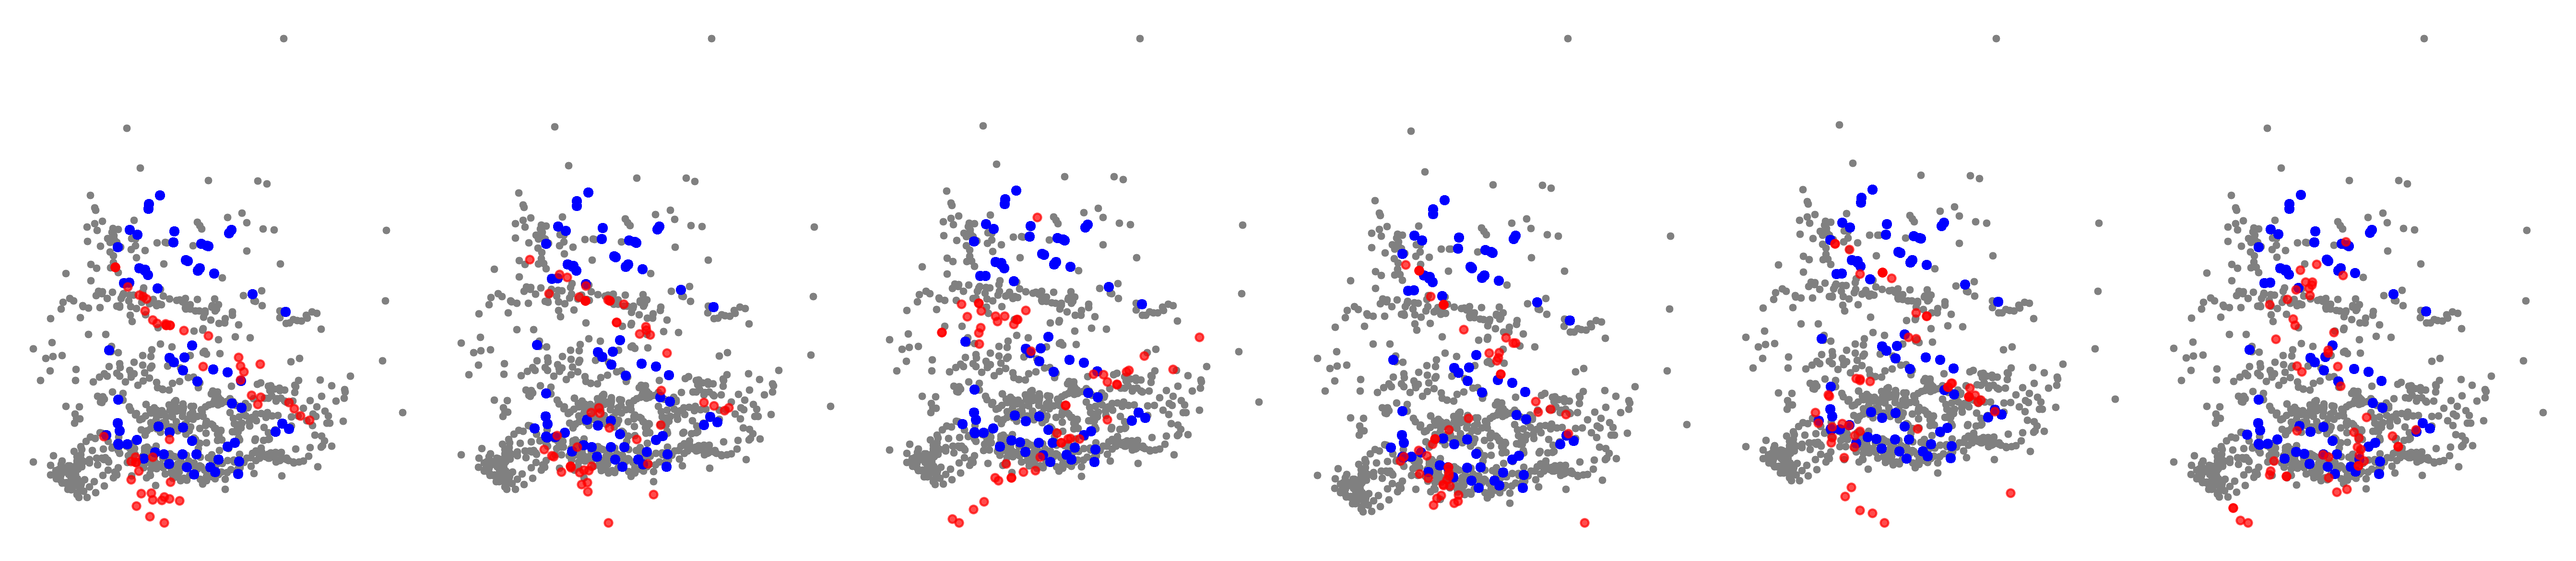

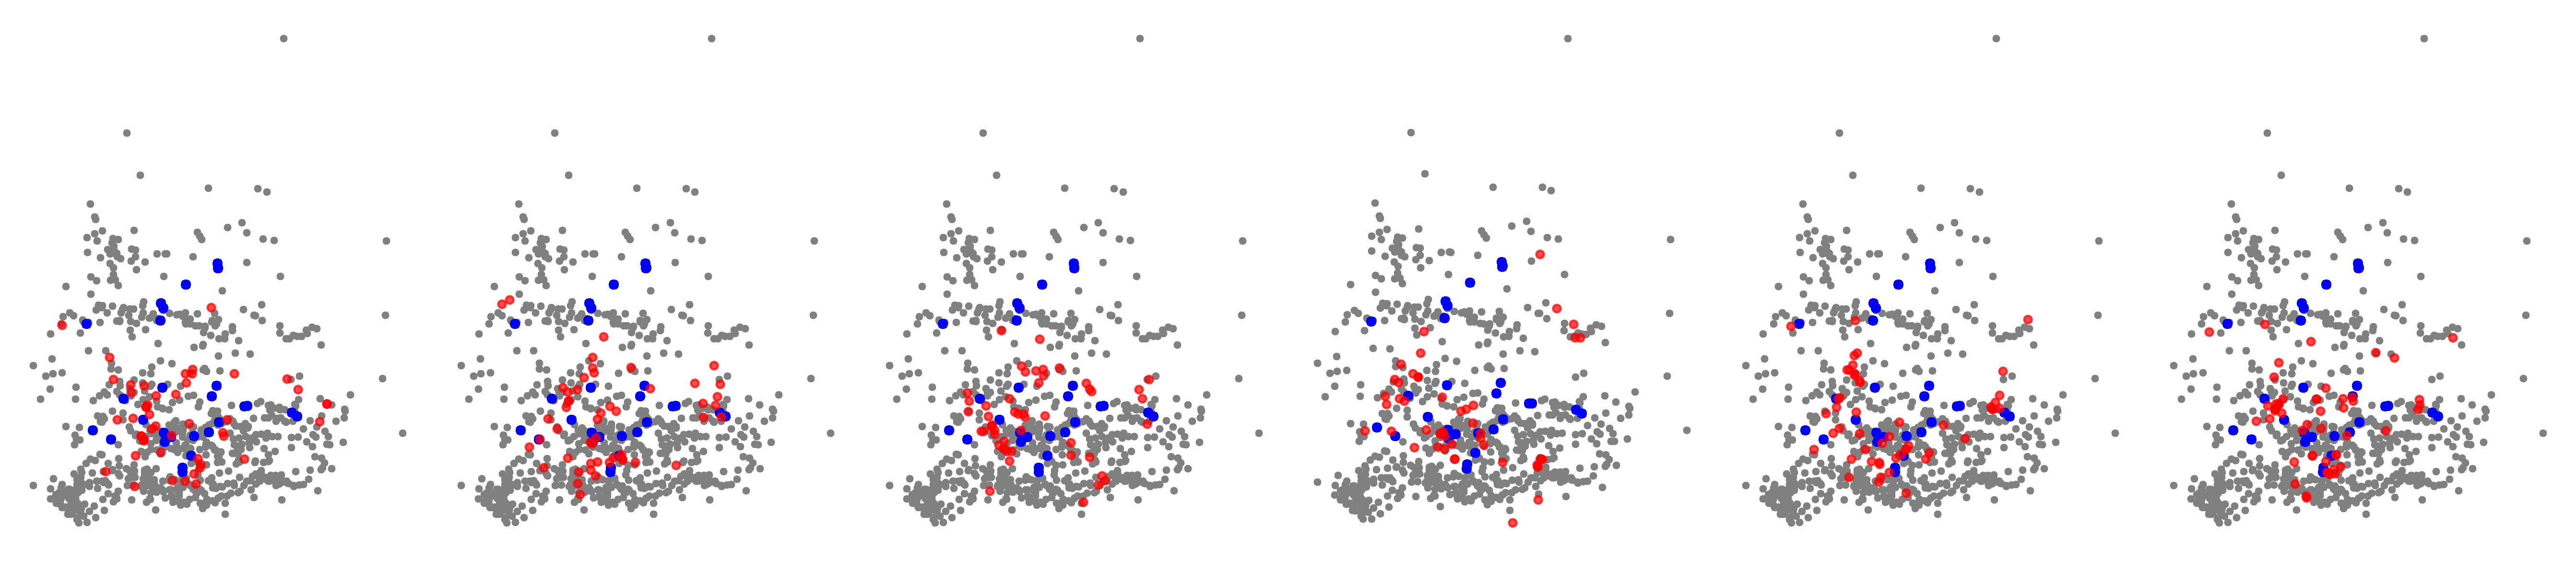

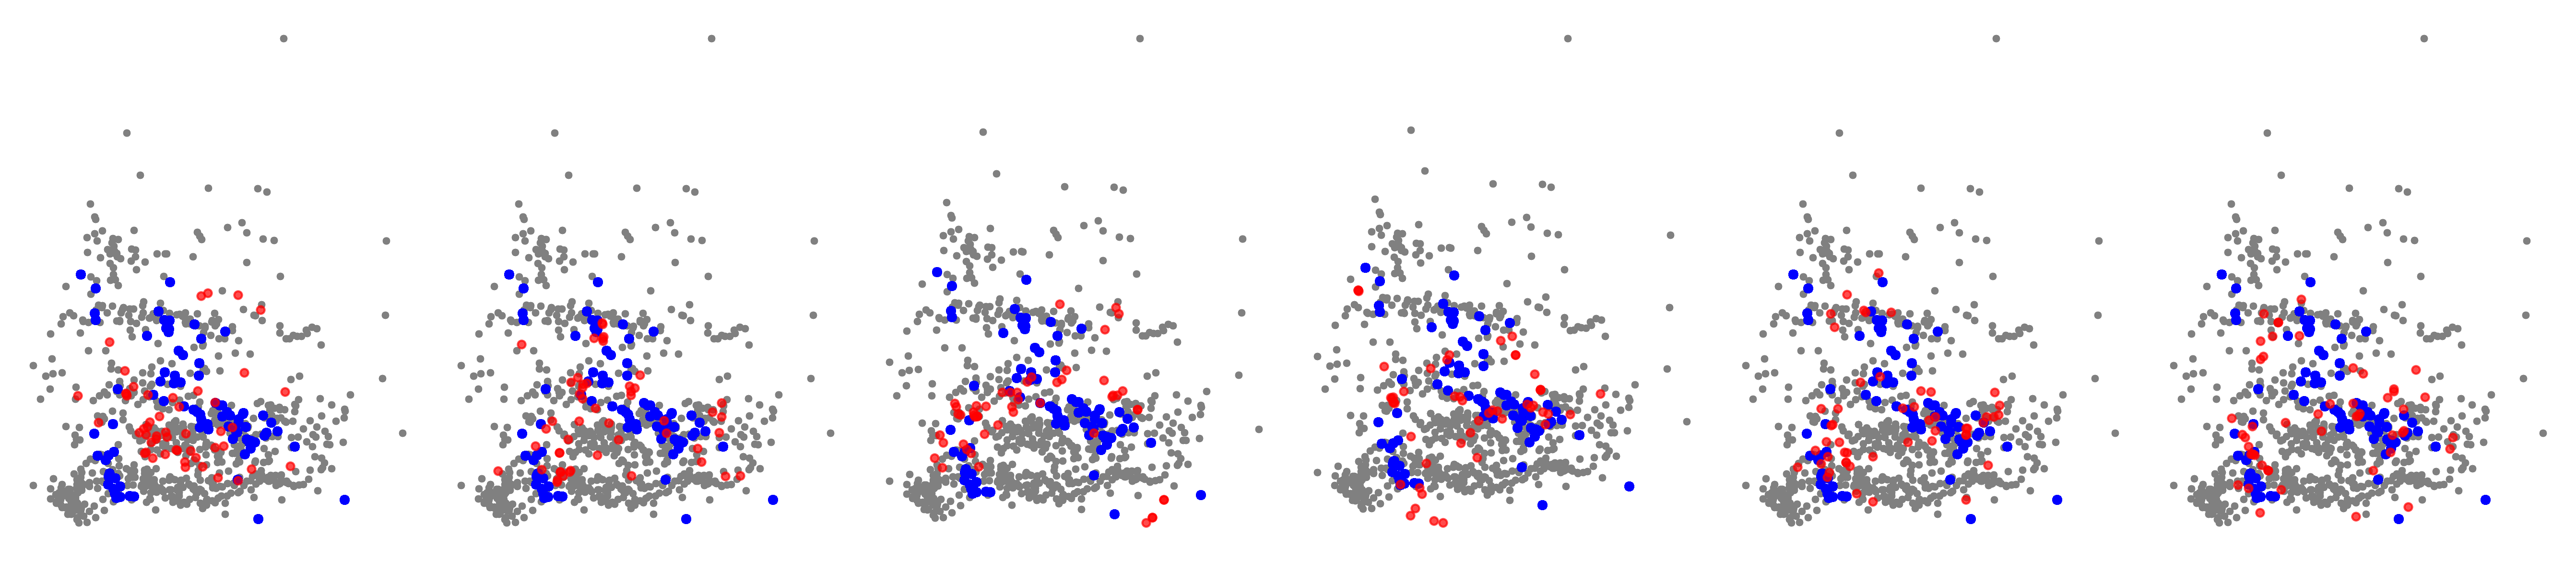

In [ ]:
# draw the scatter plotfor AFI
draw_scatter_epochs(all_vec, AFI_smiles, AFI_generate_smiles, method='PCA', epochs=6)
draw_scatter_epochs(all_vec, AEI_smiles, AEI_generate_smiles, method='PCA', epochs=6)
draw_scatter_epochs(all_vec, CHA_smiles, CHA_generate_smiles, method='PCA', epochs=6)